<a href="https://colab.research.google.com/github/abderrazzaq-laanoui/PFE-HexaCoders/blob/PreparingData/ml_ocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="text-align:center"><h1>RECONNAISSANCE DE L'ÉCRITURE MANUSCRITE DE LESTTRES TEFINAGH</h1></div>

---

# DEPANDECIES

#### Mounting Google Drive

In [1]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Imports

In [2]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import random
import pickle
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

#### Variables

In [3]:

CATEGORIES = ["ya", "yab", "yach", "yad", "yadd", "yae", "yaf", "yag", "yagh", 
              "yagw", "yah", "yahh", "yaj", "yak", "yakw", "yal", "yam", "yan", 
              "yaq", "yar","yarr", "yas", "yass", "yat", "yatt", "yaw", "yax", 
              "yay", "yaz", "yazz", "yey", "yi", "yu"] # a list of all possible classes

training_data = [] # a list that will contain processed training data
testing_data = [] # a list that will contain processed testing data

# LOADING UP THE DATASET

In [4]:

#@markdown \
#@markdown #### Entrez le chemin d'accès au répertoire DATASET dans votre Drive:
chemin = "" #@param {type:"string"}
#@markdown \

if chemin == "":
    chemin = "genie info/Rapport PFE - HexaCoders/DATASET" #default path
# Variables Declaration
DIR = os.path.join("/content/drive/MyDrive",chemin) # h the path to the DATASET dir  in your drive
TRAINDATADIR = os.path.join(DIR,"training_data/")
TESTDATADIR = os.path.join(DIR,"testing_data/")
MODELDIR = os.path.join(DIR,"model/")


#### Preparing training data

<b>OpenCV</b> (référencé par cv) est une bibliothèque multi-plateforme qui nous permet de développer des applications de vision par ordinateur en temps réel. Elle se concentre principalement sur le traitement des images en temps réel., la capture et l'analyse vidéo, y compris des fonctionnalités telles que la détection des visages et des objets.

In [ ]:
training_data = [] # a list that will contain processed training data
def prepare_training_data():
    for category in CATEGORIES :
        path = os.path.join(TRAINDATADIR, category)
        class_num = CATEGORIES.index(category)  # get the classification  (0 to 32)
        for img in os.listdir(path): # iterate over each image in a caracter folder 
            img_array = cv.imread(os.path.join(path, img), cv.IMREAD_GRAYSCALE) # read graysacled images
            new_array = cv.resize(img_array, (50,50)) # resizing images
            training_data.append([new_array, class_num]) # append processed image to the training data list

prepare_training_data() # calling the fct

Nous voulons mélanger les données. Pour l'instant, nos données ne sont que "ya", puis "yab", puis "yach" ... . Cela finit généralement par causer des problèmes, car, au début, le classificateur apprendra à prédire toujours "ya". Ensuite, il passera à prédire tout "yab" ..., Faire des allers-retours comme ça n'est pas bon non plus.

In [ ]:
# shuffle the training data randomly 
random.shuffle(training_data)

#### Creating the training model

In [5]:
# Create the model
X = [] 
Y = []

for features,label in training_data:
    X.append(features)
    Y.append(label)

#### Saving the training model

Le module <b> pickle </b> met en œuvre des protocoles binaires pour sérialiser et désérialiser une structure d'objet Python. <br><br> Le "pickling" est le processus par lequel une hiérarchie d'objets Python est convertie en un flux d'octets.

In [ ]:
# Saving the model

pickle_out = open(MODELDIR + "X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open(MODELDIR + "Y.pickle","wb")
pickle.dump(Y, pickle_out)
pickle_out.close()

#### Uploading the training model

Le "unpickling" est l'opération inverse, par laquelle un flux d'octets (provenant d'un fichier binaire ou d'un objet de type octet) est reconverti en une hiérarchie d'objets.

In [6]:
# to load the model we use the script
pickle_in = open(MODELDIR + "X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open(MODELDIR + "Y.pickle","rb")
Y = pickle.load(pickle_in)

# CREATING THE CONVOLUTIONAL NURAL NETWORK

#### CNN Configurations 

In [9]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

#### Data-dimensions for convenience

In [10]:
# The number of pixels in each dimension of an image.
img_size = 50

# The images are stored in one-dimensional arrays of this length.
img_size_flat = 50*50

# Tuple with height and width of images used to reshape arrays.
img_shape = (50, 50)

# Number of classes, one class for each of 33 alphabet.
num_classes = 33

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

#### Helper-function for plotting images


In [61]:
# TODO
def plot_image(image, cls_true, cls_pred=None):
    
   
    plt.imshow(images.reshape(img_shape), cmap='gray')

        # Show true and predicted classes.
    if cls_pred is None:
        #plt.(.5,.9,'Temperature', fontsize=100, ha='center')
        plt.figtext("True: {0}".format(cls_true)
    else:
        #plt.figtext(.5,.9,'Temperature', fontsize=100, ha='center')
        plt.figtext = "True: {0}, Pred: {1}".format(cls_true, cls_pred)
        
    plt.axis('off')

    plt.show()

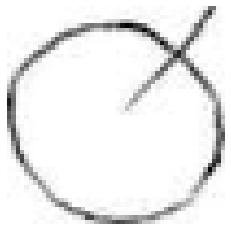

In [62]:
images = X[1]

# Get the true classes for those images.
cls_true = Y[1]

# Plot the images and labels using our helper-function above.
plot_image(image=images, cls_true=cls_true)